# 설치

In [ ]:
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 4.2 MB/s eta 0:00:00


# 프로그램 개요

- 5일간의 data를 모아서 6일째 종가를 예측하는 프로그램

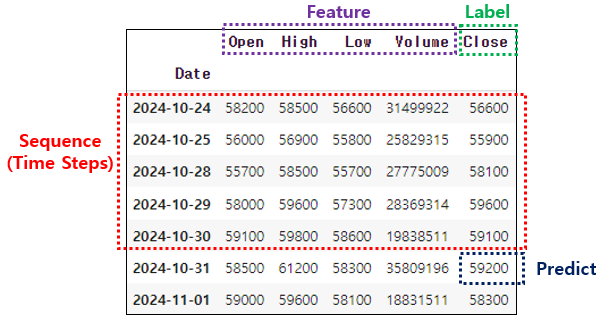

# 데이터 준비

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device = {device}')
print(f'torch.__version__ = {torch.__version__}, fdr.__version__ = {fdr.__version__}')

# Hyper parameter
FEATURE_NUMS        = 4     # 입력층으로 들어가는 data의 수(Open, High, Low, Volume)
SEQ_LENGTH          = 5     # 정답을 만들기 위해 필요한 시점 수, time steps
HIDDEN_SIZE         = 4     # RNN layer를 구성하는 hidden state 수
NUM_LAYERS          = 1     # RNN layer가 몇 겹으로 쌓여 있는지
LEARNING_RATE       = 1e-3  # 학습률
BATCH_SIZE          = 20    # batch size
EPOCHS              = 200   # 학습 횟수
TRAINING_DATA_RATE  = 0.7   # 전체 data 중 train data의 비율

device = cpu
torch.__version__ = 2.5.0+cu121, fdr.__version__ = 0.9.94


In [ ]:
# 2020년 이후 삼성전자 주가 가져오기
df = fdr.DataReader('005930', '2020-01-01', '2024-11-01') # '005930': 삼성전자 종목번호
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1191 entries, 2020-01-02 to 2024-11-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1191 non-null   int64  
 1   High    1191 non-null   int64  
 2   Low     1191 non-null   int64  
 3   Close   1191 non-null   int64  
 4   Volume  1191 non-null   int64  
 5   Change  1191 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 65.1 KB


In [ ]:
# 필요한 column만
df = df[['Open', 'High', 'Low', 'Volume', 'Close']]
df.tail(7)

,Open,High,Low,Volume,Close
Date,,,,,
2024-10-24,58200,58500,56600,31499922,56600
2024-10-25,56000,56900,55800,25829315,55900
2024-10-28,55700,58500,55700,27775009,58100
2024-10-29,58000,59600,57300,28369314,59600
2024-10-30,59100,59800,58600,19838511,59100
2024-10-31,58500,61200,58300,35809196,59200
2024-11-01,59000,59600,58100,19083180,58300


In [ ]:
# 7:3 비율로 train/test data 생성
# TRAINING_DATA_RATE  = 0.7   # 전체 data 중 train data의 비율
SPLIT = int(len(df) * TRAINING_DATA_RATE) # train : test = 7 : 3
df_train = df[:SPLIT]
df_test = df[SPLIT:]

In [ ]:
# Outlier의 영향을 최소화하기 위해 data를 0~1 사이의 값으로 정규화
# feature  scaling
scaler_x = MinMaxScaler()
scaler_x.fit(df_train.iloc[:, :-1])
df_train_x_scaled = scaler_x.transform(df_train.iloc[:, :-1])
df_test_x_scaled = scaler_x.transform(df_test.iloc[:, :-1])

# label scaling
scaler_y = MinMaxScaler()
scaler_y.fit(df_train.iloc[:, [-1]])
df_train_y_scaled = scaler_y.transform(df_train.iloc[:, [-1]])
df_test_y_scaled = scaler_y.transform(df_test.iloc[:, [-1]])

In [ ]:
# Sequence Data를 만들어 주는 함수
def MakeSequenceData(data_x, data_y, seq_length):
  seq_x = []
  seq_y = []

  for i in range(len(data_x) - seq_length):
    # featrue 4개인 data를 5일치를 모아서
    seq_x.append(data_x[i:i+seq_length, :]) # DataFrame
    # 이어지는 6일째의 종가
    seq_y.append(data_y[i+seq_length])      # Series

  return torch.FloatTensor(np.array(seq_x)).to(device), torch.FloatTensor(np.array(seq_y)).to(device)

# Sequence Length가 SEQ_LENGTH, 즉 time step 수가 SEQ_LENGTH인 train data, test data 생성
# tensor로 변경하기 위해 DataFrame => Numpy로 casting
train_x, train_y = MakeSequenceData(np.array(df_train_x_scaled), np.array(df_train_y_scaled), SEQ_LENGTH)
test_x, test_y = MakeSequenceData(np.array(df_test_x_scaled), np.array(df_test_y_scaled), SEQ_LENGTH)

print(f'train_x.shape = {train_x.shape}, train_y.shape = {train_y.shape}')
print(f'test_x.shape = {test_x.shape}, test_y.shape = {test_y.shape}')

train_x.shape = torch.Size([828, 5, 4]), train_y.shape = torch.Size([828, 1])
test_x.shape = torch.Size([353, 5, 4]), test_y.shape = torch.Size([353, 1])


In [ ]:
# Dataset 생성
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'len(train_dataloader) = {len(train_dataloader)}, len(test_dataloader) = {len(test_dataloader)}')

len(train_dataloader) = 42, len(test_dataloader) = 18


# Model 정의

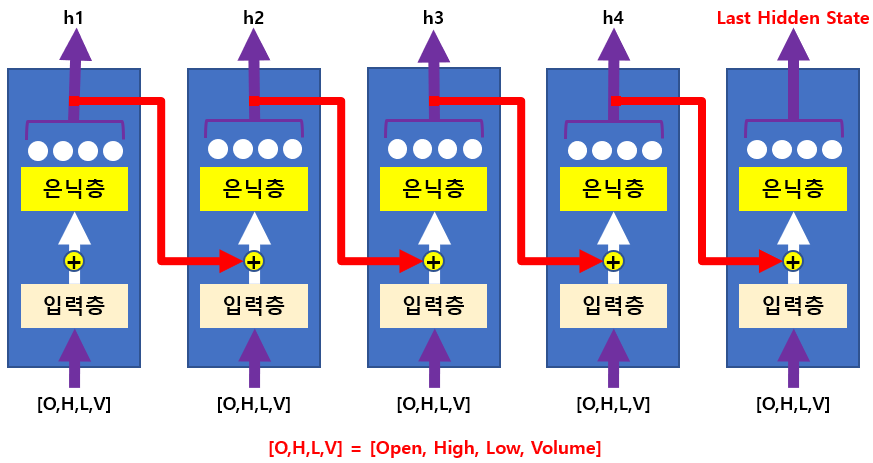

In [ ]:
# FEATURE_NUMS        = 4     # 입력층으로 들어가는 data의 수(Open, High, Low, Volume)
# SEQ_LENGTH          = 5     # 정답을 만들기 위해 필요한 시점 수, time steps
# BATCH_SIZE          = 20    # batch size
# HIDDEN_SIZE         = 4     # RNN layer를 구성하는 hidden state 수, RNN layer의 출력값의 수
# NUM_LAYERS          = 1     # RNN layer가 몇 겹으로 쌓여 있는지
# feature - 4, time_steps(sequence) - 5, batch-size: 20 => 입력 데이터 - (20, 5, 4)
class GruModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, data):  # data.shape = torch.Size([20, 5, 4])
    # hidden state (1, 20, 4)
    h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(device)  # h0.shape = torch.Size([1, 20, 4])

    # outputs.size() - (batch_size=20, time_stpes=5, hidden_size=4)
    outputs, _ = self.gru(data, h0)  # outputs.shape = torch.Size([20, 5, 4])
    # last_hs.size() - (batch_size=20, hidden_size=4)
    last_hs = outputs[:, -1, :] # 마지막 hidden state, last_hs.shape = torch.Size([20, 4])
    prediction = self.fc(last_hs) # prediction.shape = torch.Size([20, 1])

    return prediction

model = GruModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(device)
print(model)

criterion = nn.MSELoss()  # 주식 가격이므로
# LEARNING_RATE       = 1e-3  # 학습률
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

GruModel(
  (gru): GRU(4, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


## sample

In [ ]:
outputs = torch.rand(2, 5, 4)
print(outputs)
last_hs = outputs[:, -1, :]
print(last_hs)
fc = nn.Linear(4, 1)
prediction = fc(last_hs)
print(prediction)
print(f'outputs.shape = {outputs.shape}')
print(f'last_hs.shape = {last_hs.shape}')

tensor([[[0.8787, 0.8495, 0.7964, 0.4614],
         [0.5465, 0.9142, 0.3763, 0.0115],
         [0.7004, 0.8930, 0.6856, 0.5974],
         [0.3424, 0.2748, 0.9418, 0.5138],
         [0.9107, 0.7210, 0.5657, 0.7908]],

        [[0.7784, 0.0422, 0.4269, 0.5105],
         [0.8469, 0.7280, 0.7195, 0.6116],
         [0.6609, 0.1513, 0.8481, 0.0713],
         [0.8703, 0.1583, 0.4002, 0.3521],
         [0.2520, 0.5651, 0.2559, 0.1234]]])
tensor([[0.9107, 0.7210, 0.5657, 0.7908],
        [0.2520, 0.5651, 0.2559, 0.1234]])
tensor([[-0.0608],
        [-0.2020]], grad_fn=<AddmmBackward0>)
outputs.shape = torch.Size([2, 5, 4])
last_hs.shape = torch.Size([2, 4])


In [ ]:
input_data = torch.Tensor([[[58200,	58500,	56600,	31499922],
                            [56000,	56900,	55800,	25829315],
                            [55700,	58500,	55700,	27775009],
                            [58000,	59600,	57300,	28369314],
                            [59100,	59800,	58600,	19838511]]])
gruModel = torch.nn.GRU(
              input_size=4,  # 입력: 4, 4개의 feature
              hidden_size=4, # 출력: 4, 4개의 hidden state, 따라서 출력도 4개
              batch_first=True)

outputs, last_hs = gruModel(input_data)
# outputs: LSTM의 모든 시점(timestamp)에서의 hidden state, [h1, h2, h3, h4, h5]
# outputs.size() - (batch_size, time_stpes, hidden_size) = (1, 5, 4)
# last_hs: 마지막 시점(timestamp)의 hidden state, [h5]
# last_hs.size() - (1, batch_size, hidden_size) = (1, 1, 4)

print(f'input_data.size() = {input_data.size()}') # input_data.size() = torch.Size([1, 5, 4]), (batch_size=3, time_steps=4, featrue=1)
print(f'outputs.size() = {outputs.size()}')       # outputs.size() = torch.Size([1, 5, 4]), (batch_size=1, time_stpes=5, hidden_size=4)
print(f'outputs = {outputs}')
print(f'last_hs.size() = {last_hs.size()}')       # last_hs.size() = torch.Size([1, 1, 4]), (num_layers=1, batch_size=1, hidden_size=3)
print(f'last_hs = {last_hs}')

input_data.size() = torch.Size([1, 5, 4])
outputs.size() = torch.Size([1, 5, 4])
outputs = tensor([[[ 0., -1.,  0.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 0., -1.,  0.,  0.],
         [ 0., -1.,  0.,  0.]]], grad_fn=<TransposeBackward1>)
last_hs.size() = torch.Size([1, 1, 4])
last_hs = tensor([[[ 0., -1.,  0.,  0.]]], grad_fn=<StackBackward0>)


# 학습

In [ ]:
def model_train(dataloader, model, criterion, optimizer):

  model.train()

  train_loss_sum = 0
  total_train_batch = len(dataloader)

  '''
  ### Debug ####################################
  index = 0
  ### Debug ####################################
  '''

  for inputs, labels in dataloader:
    x_train = inputs.to(device) # ['Open', 'High', 'Low', 'Volume']
    y_train = labels.to(device) # ['Close']

    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    '''
    ### Debug ####################################
    if index > 0:
      break
    index += 1

    # 20: batch size
    print(f'inputs.shape = {inputs.shape}')       # inputs.shape = torch.Size([20, 5, 4])
    print(f'labels.shape = {labels.shape}')       # labels.shape = torch.Size([20, 1])
    print(f'x_train.shape = {x_train.shape}')     # x_train.shape = torch.Size([20, 5, 4])
    print(f'y_train.shape = {y_train.shape}')     # y_train.shape = torch.Size([20, 1])
    print(f'y_train.type() = {y_train.type()}')   # y_train.type() = torch.FloatTensor
    print(f'y_train.size() = {y_train.size()}')   # y_train.size() = torch.Size([20, 1])
    print(f'y_train.size(0) = {y_train.size(0)}') # y_train.size(0) = 20
    print(f'outputs.shape = {outputs.shape}')     # outputs.shape = torch.Size([20, 1])
    ### Debug ####################################
    '''

  train_avg_loss = train_loss_sum / total_train_batch
  return train_avg_loss

'''
### Debug ####################################
model_train(train_dataloader, model, criterion, optimizer)
### Debug ####################################
'''

'\n### Debug ####################################\nmodel_train(train_dataloader, model, criterion, optimizer)\n### Debug ####################################\n'

In [ ]:
def model_eval(dataloader, model, criterion, optimizer):

  model.eval()

  with torch.no_grad():

    eval_loss_sum = 0
    total_batch_sum = len(dataloader)

    for inputs, labels in dataloader:
      x_eval = inputs.to(device)
      y_eval = labels.to(device)

      outputs = model(x_eval)
      loss = criterion(outputs, y_eval)

      eval_loss_sum += loss.item()

    eval_avg_loss = eval_loss_sum / total_batch_sum

  return eval_avg_loss

In [ ]:
from datetime import datetime

start_time = datetime.now()

train_loss_list = []
for epoch in range(EPOCHS):
  train_loss = model_train(train_dataloader, model, criterion, optimizer)
  train_loss_list.append(train_loss)
  if (epoch % 10 == 0 ):
    print(f'epoch: {epoch}, train_loss: {train_loss}')

end_time = datetime.now()
print(f'elapsed time => {end_time - start_time}')

epoch: 0, train_loss: 0.2453666946717671
epoch: 10, train_loss: 0.010614478220564447
epoch: 20, train_loss: 0.001995155978961737
epoch: 30, train_loss: 0.0012235037159241205
epoch: 40, train_loss: 0.0011627847332939772
epoch: 50, train_loss: 0.0011088066634589008
epoch: 60, train_loss: 0.0010577775156846094
epoch: 70, train_loss: 0.0010107550808156486
epoch: 80, train_loss: 0.0009675371613758173
epoch: 90, train_loss: 0.0009273159774325212
epoch: 100, train_loss: 0.0008895594489461343
epoch: 110, train_loss: 0.0008542810794010404
epoch: 120, train_loss: 0.0008220099241173427
epoch: 130, train_loss: 0.0007936586542720241
epoch: 140, train_loss: 0.0007701853620736594
epoch: 150, train_loss: 0.0007520787146945839
epoch: 160, train_loss: 0.0007389728128882347
epoch: 170, train_loss: 0.0007296668080103007
epoch: 180, train_loss: 0.0007226620804257912
epoch: 190, train_loss: 0.0007167983553483195
elapsed time => 0:00:31.603587


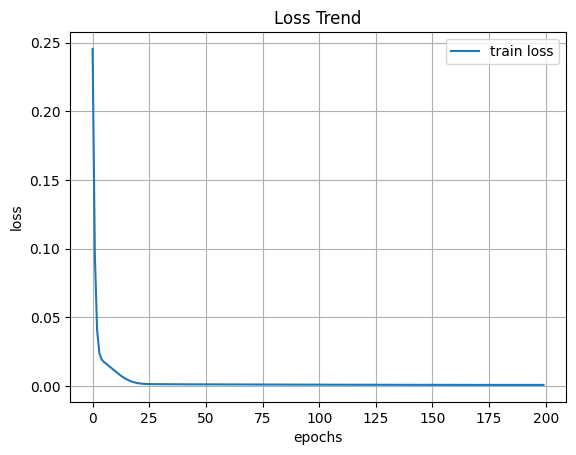

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train loss')
plt.legend()
plt.show()

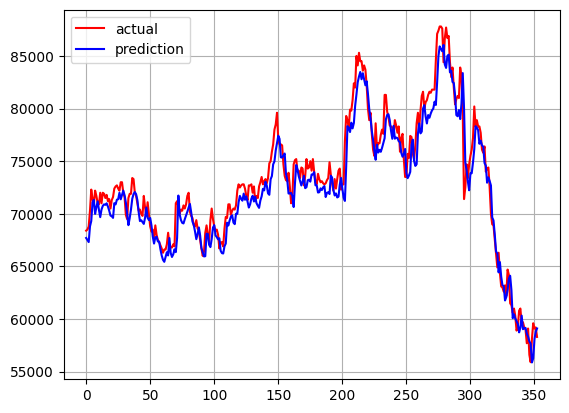

In [ ]:
# test data에 대한 예측 수행
predition = model(test_x).detach().cpu().numpy()

# scaling되기 전의 원래 값으로 변경
pred_price = scaler_y.inverse_transform(predition)

price = test_y.detach().cpu().numpy()
actual_price = scaler_y.inverse_transform(price)

plt.plot(actual_price, color='red', label='actual')
plt.plot(pred_price, color='blue', label='prediction')
plt.grid()
plt.legend()

plt.show()